In [7]:
%load_ext watermark
%watermark -u -n -t -z -v -p numpy,scipy,neupy,scikit-learn,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Dec 26 2016 21:01:28 EET

CPython 3.4.3
IPython 5.1.0

numpy 1.11.2
scipy 0.18.1
neupy 0.4.1.dev0
scikit-learn 0.18
matplotlib 1.5.3


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

## VGG19

In [9]:
from neupy import layers, environment

environment.speedup()

vgg19 = layers.join(
    layers.Input((3, 224, 224)),

    layers.Convolution((64, 3, 3), padding=1, name='conv1_1') > layers.Relu(),
    layers.Convolution((64, 3, 3), padding=1, name='conv1_2') > layers.Relu(),   
    layers.MaxPooling((2, 2)),

    layers.Convolution((128, 3, 3), padding=1, name='conv2_1') > layers.Relu(),
    layers.Convolution((128, 3, 3), padding=1, name='conv2_2') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((256, 3, 3), padding=1, name='conv3_1') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_2') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_3') > layers.Relu(),
    layers.Convolution((256, 3, 3), padding=1, name='conv3_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((512, 3, 3), padding=1, name='conv4_1') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_2') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_3') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv4_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),

    layers.Convolution((512, 3, 3), padding=1, name='conv5_1') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_2') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_3') > layers.Relu(),
    layers.Convolution((512, 3, 3), padding=1, name='conv5_4') > layers.Relu(),
    layers.MaxPooling((2, 2)),
    
    layers.Reshape(),
    
    layers.Relu(4096, name='dense_1') > layers.Dropout(0.5),
    layers.Relu(4096, name='dense_2') > layers.Dropout(0.5),
    layers.Softmax(1000, name='dense_3'),
)

## Download VGG19 pre-trained weights

In [10]:
import os
import requests
from tqdm import tqdm

def download_file(url, filepath, description=''):
    head_response = requests.head(url)
    filesize = int(head_response.headers['content-length'])

    response = requests.get(url, stream=True)
    chunk_size = int(1e7)

    n_iter = (filesize // chunk_size) + 1

    print(description)
    print('URL: {}'.format(url))
    with open(filepath, "wb") as handle:
        for data in tqdm(response.iter_content(chunk_size), total=n_iter):
            handle.write(data)

    print('Downloaded sucessfully')
    

FILES_DIR = os.path.join('files')
VGG19_WEIGHTS_FILE = os.path.join(FILES_DIR, 'vgg19.pickle')

if not os.path.exists(FILES_DIR):
    os.mkdir(FILES_DIR)

if not os.path.exists(VGG19_WEIGHTS_FILE):
    download_file(
        url=(
            "http://srv70.putdrive.com/putstorage/DownloadFileHash/"
            "F9A70DEA3A5A4A5QQWE2301487EWQS/vgg19.pickle"
        ),
        filepath=VGG19_WEIGHTS_FILE,
        description='Downloading weights'
    )

In [11]:
from neupy import storage
storage.load(vgg19, VGG19_WEIGHTS_FILE)

## Visualize learned features by different filters in different layers

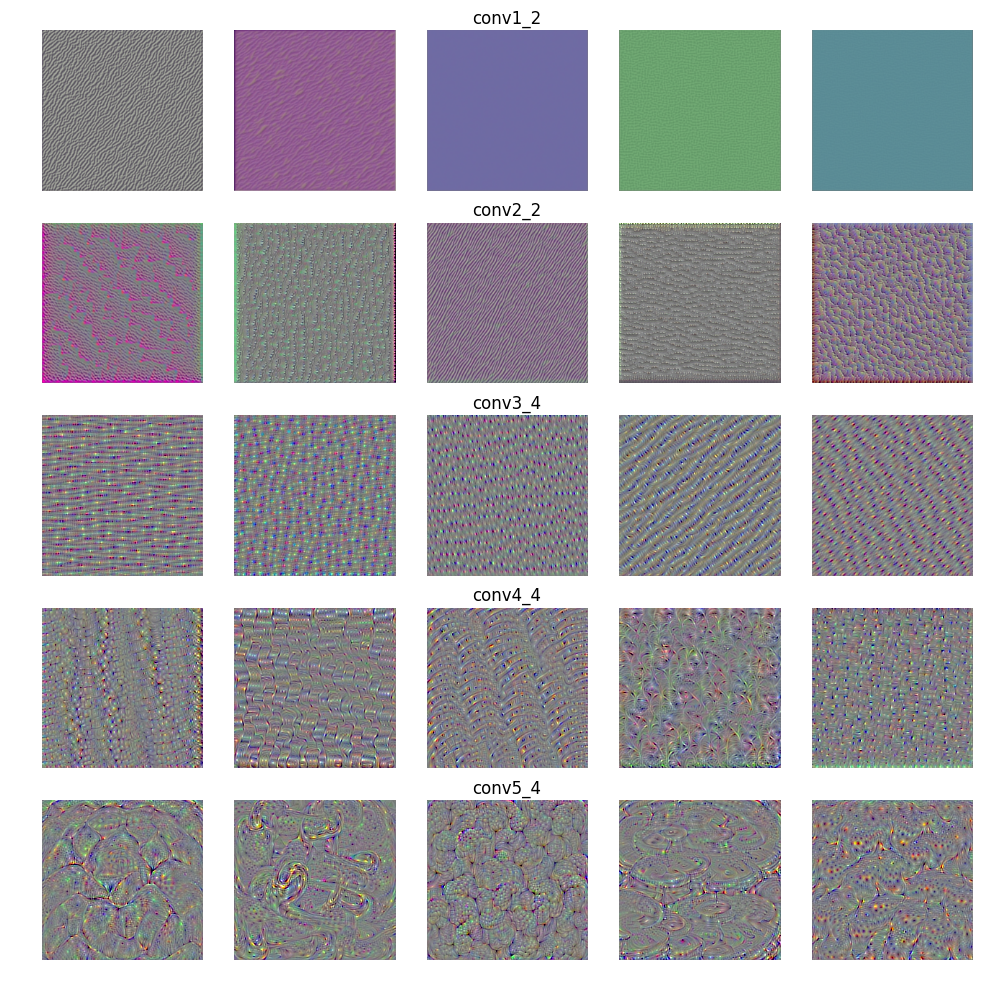

In [12]:
from itertools import product
import theano
import theano.tensor as T
import numpy as np
from tqdm import tqdm

def normalize(input_img_data):
    x = input_img_data[0]
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

layer_names = ('conv1_2', 'conv2_2', 'conv3_4', 'conv4_4', 'conv5_4')
fig, axes = plt.subplots(len(layer_names), 5, figsize=(12, 12))

for i, output_layer_name in enumerate(layer_names):
    desc = "{} layer".format(output_layer_name)
    
    x = T.tensor4()
    res = vgg19.end(output_layer_name).output(x)
    row_axes = axes[i]
    
    for j in tqdm(list(range(5)), desc=desc):
        loss = T.mean(res[:, j, :, :])
        grad = T.grad(loss, x)
        grad /= (T.sqrt(T.mean(T.square(grad))) + 1e-7)
        iterate = theano.function([x], [loss, grad])

        # we start from a gray image with some noise
        input_img_data = (np.random.random((1, 3, 224, 224)) * 20 + 128).astype(np.float32)

        step = 100.
        for _ in range(20):
            loss_value, grads_value = iterate(input_img_data)
            input_img_data = input_img_data + grads_value * step

        input_img_data = normalize(input_img_data)
        
        row_axes[j].imshow(input_img_data[:, :, ::-1])
        row_axes[j].axis('off')
        
    row_axes[2].set_title(output_layer_name)

## Saliency map

In [13]:
from scipy.misc import imresize, imread

def load_image(image_name, image_size=None, crop_size=None, use_bgr=True):
    image = imread(image_name)

    if image_size is not None:
        image = imresize(image, image_size)

    if crop_size is not None:
        image = image[
            slice(
                (image_size[0] - crop_size[0]) // 2,
                (image_size[0] + crop_size[0]) // 2,
            ),
            slice(
                (image_size[1] - crop_size[1]) // 2,
                (image_size[1] + crop_size[1]) // 2,
            ),
            :,
        ]

    if use_bgr:
        # RGB -> BGR
        image[:, :, (0, 1, 2)] = image[:, :, (2, 1, 0)]

    image = image.astype('float32')

    # Normalize channels (based on the pretrained VGG16 configurations)
    image[:, :, 0] -= 123.68
    image[:, :, 1] -= 116.779
    image[:, :, 2] -= 103.939

    # (height, width, channel) -> (channel, height, width)
    image = image.transpose((2, 0, 1))
    # (channel, height, width) -> (1, channel, height, width)
    image = np.expand_dims(image, axis=0)

    return image

dog = load_image('images/dog.jpg', image_size=(256, 256),
                 crop_size=(224, 224))

In [14]:
def compile_saliency_map(network):
    x = T.tensor4()

    with network.disable_training_state():
        output = network.output(x)
        
    max_output = T.max(output, axis=1)
    saliency = T.grad(T.sum(max_output), x)

    return theano.function([x], saliency)
    
saliency_map = compile_saliency_map(vgg19)

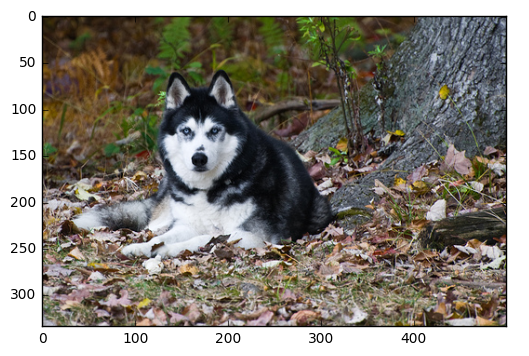

In [15]:
plt.imshow(imread('images/dog.jpg'))

In [16]:
dog_saliency = saliency_map(dog)    
dog_saliency.shape

(1, 3, 224, 224)

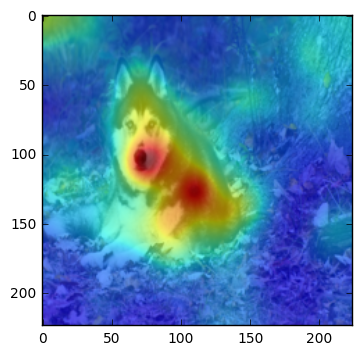

In [17]:
from scipy.ndimage.filters import gaussian_filter

def asimage(image):
    return image[0, :, :, :].transpose((1, 2, 0))

def deprocess(image):
    image = image.copy()
    
    image[:, :, 0] += 123.68
    image[:, :, 1] += 116.779
    image[:, :, 2] += 103.939

    image[:, :, (0, 1, 2)] = image[:, :, (2, 1, 0)]
    
    return image.astype(np.int64)

saliency = asimage(dog_saliency)
saliency = saliency.max(axis=2)

plt.imshow(-deprocess(asimage(dog)))
plt.imshow(gaussian_filter(saliency, sigma=10), alpha=0.6, vmin=0)

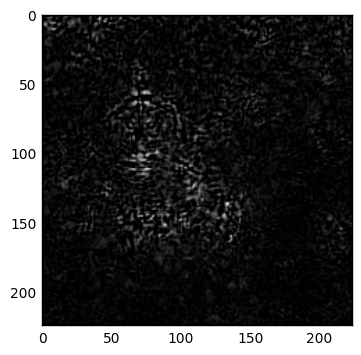

In [18]:
plt.imshow(saliency, cmap='gray', vmin=0)